# Visualize Top Geneset Feature Distribution

**Gregory 2019**

Here, I visualize the dimension of the top scoring feature across various geneset collections.

In [1]:
#install.packages('dplyr')
#install.packages('ggplot2')
#install.packages('cowplot')
install.packages('reshape2')

Installing package into ‘/home/paperspace/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



In [2]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

In [3]:
algorithms <- c("PCA", "ICA", "NMF", "DAE", "VAE")
datasets <- c("TCGA", "TARGET", "GTEX")
collections <- c("GpXCELL",
                 "GpC4CM",
                 "GpH",
                 "GpC2CPG",
                 "GpC2CPREACTOME",
                 "GpC3TFT")

In [4]:
base_dir <- file.path("results", "top_features")

all_top_list <- list()
list_idx <- 1
for (top_file in list.files(base_dir)) {
    if (grepl("top_biobombe_scores", top_file)) {
        dataset <- strsplit(top_file, '_')[[1]][1]
        collection <- strsplit(top_file, '_')[[1]][2]

        top_df <- readr::read_tsv(file.path(base_dir, top_file),
                                col_types = readr::cols(
                                    .default = readr::col_character(),
                                    value = readr::col_double(),
                                    z_score = readr::col_double(),
                                    feature = readr::col_integer(),
                                    z = readr::col_integer(),
                                    abs_z_score = readr::col_double(),
                                    relative_geneset_rank = readr::col_integer(),
                                    absolute_rank = readr::col_integer())) %>%
        dplyr::mutate(collection = collection,
                      dataset = dataset)
        
        all_top_list[[list_idx]] <- top_df
        list_idx <- list_idx + 1
    }
}

In [5]:
all_top_df <- dplyr::bind_rows(all_top_list) %>%
    dplyr::filter(collection %in% collections)

In [6]:
# Covert z score to p value and generate bonferonni adjusted alphas
all_top_df <- all_top_df %>%
    dplyr::mutate(p_val = 2 * pnorm(-abs_z_score)) %>%
    dplyr::group_by(z) %>%
    dplyr::mutate(bon_alpha = 0.05 / z) %>%
    dplyr::ungroup() %>%
    dplyr::mutate(is_bon_filtered = bon_alpha < p_val)

In [7]:
# Process data for plotting
all_top_df$z <- factor(all_top_df$z,
                       levels = sort(as.numeric(paste(unique(all_top_df$z)))))

all_top_df <- all_top_df %>%
    dplyr::group_by(z, collection, dataset, algorithm) %>% 
    dplyr::mutate(num_instance = dplyr::n()) %>%
    dplyr::mutate(normalized_z = num_instance / as.numeric(paste(z))) %>%
    dplyr::ungroup() %>%
    dplyr::mutate(algorithm = toupper(algorithm))

all_top_df$algorithm <- factor(all_top_df$algorithm, levels = algorithms)
all_top_df$collection <- factor(all_top_df$collection, levels = collections)

In [8]:
print(dim(all_top_df))
head(all_top_df)

[1] 35405    18


model_type,variable,value,z_score,algorithm,feature,z,seed,abs_z_score,relative_geneset_rank,absolute_rank,collection,dataset,p_val,bon_alpha,is_bon_filtered,num_instance,normalized_z
<chr>,<chr>,<dbl>,<dbl>,<fct>,<int>,<fct>,<chr>,<dbl>,<int>,<int>,<fct>,<chr>,<dbl>,<dbl>,<lgl>,<int>,<dbl>
real,Erythrocytes_BLUEPRINT_1,1.73053,74.5482,NMF,82,150,908341,74.5482,1,1,GpXCELL,GTEX,0,0.0003333333,FALSE,88,0.5866667
real,Skeletal-muscle_FANTOM_1,38.99190,66.1139,NMF,36,200,165158,66.1139,1,2,GpXCELL,GTEX,0,0.0002500000,FALSE,252,1.2600000
real,Hepatocytes_HPCA_1,-2.88578,-61.0183,VAE,150,200,978124,61.0183,1,3,GpXCELL,GTEX,0,0.0002500000,FALSE,97,0.4850000
real,Neutrophils_HPCA_1,1.33523,60.3401,NMF,82,150,165158,60.3401,1,4,GpXCELL,GTEX,0,0.0003333333,FALSE,88,0.5866667
real,Pericytes_ENCODE_1,5.36249,59.6297,NMF,77,125,908341,59.6297,1,5,GpXCELL,GTEX,0,0.0004000000,FALSE,53,0.4240000
real,Keratinocytes_HPCA_3,19.96010,59.5659,NMF,169,200,908341,59.5659,1,6,GpXCELL,GTEX,0,0.0002500000,FALSE,252,1.2600000


In [9]:
# How many genesets are filtered
filtered_genesets_df <- reshape2::melt(all_top_df,
                                       id.vars = c("algorithm",
                                                   "dataset",
                                                   "collection"),
                                       measure.vars = 'is_bon_filtered',
                                       value.name = "filtered") %>%
    dplyr::group_by(algorithm, dataset, collection) %>%
    dplyr::summarize(num_filtered = sum(filtered),
                     percent_filtered = sum(filtered) / n()) %>%
    dplyr::arrange(desc(num_filtered))

out_file <- file.path("results", "bonferonni_filtered_counts.tsv")
readr::write_tsv(filtered_genesets_df, out_file)

filtered_genesets_df

`summarise()` has grouped output by 'algorithm', 'dataset'. You can override
using the `.groups` argument.


algorithm,dataset,collection,num_filtered,percent_filtered
<fct>,<chr>,<fct>,<int>,<dbl>
PCA,TCGA,GpC2CPG,171,0.050591716
PCA,TCGA,GpXCELL,107,0.218813906
PCA,GTEX,GpXCELL,68,0.139059305
ICA,TCGA,GpXCELL,45,0.092024540
ICA,TCGA,GpC2CPG,39,0.011538462
PCA,TCGA,GpC2CPREACTOME,38,0.056379822
DAE,TCGA,GpXCELL,36,0.073619632
PCA,TARGET,GpC4CM,33,0.076566125
NMF,TCGA,GpXCELL,29,0.059304703


In [10]:
# Perform Bonferonni Correction
filtered_top_df <- all_top_df %>%
    dplyr::filter(!is_bon_filtered)

In [11]:
# Split TCGA, GTEx, and TARGET data
tcga_top_df <- filtered_top_df %>%
  dplyr::filter(dataset == "TCGA")

gtex_top_df <- filtered_top_df %>%
  dplyr::filter(dataset == "GTEX")

target_top_df <- filtered_top_df %>%
  dplyr::filter(dataset == "TARGET")

## Visualize Results

In [12]:
plot_top_feature_distribution <- function(top_df, density_how = "fill") {
    g <- ggplot(data = top_df,
                aes(x = z,
                    fill = collection,
                    group = collection)) +
    geom_density(alpha = 0.5,
                 position = density_how) +
    coord_flip() +
    scale_fill_manual(name = "",
                      values = c("GpC2CPG" = "#0F1FFF",
                                 "GpC2CPREACTOME" = "green",
                                 "GpC3TFT" = "#EDF67D",
                                 "GpH" = "#49DCB1",
                                 "GpC4CM" = "#7D82B8",
                                 "GpXCELL" = "#EF767A"),
                    labels = c("GpC2CPG" = "Perturbations (C2CGP)", 
                               "GpC2CPREACTOME" = "Pathways (REACTOME)",
                               "GpC3TFT" = "TF Targets (C3TFT)",
                               "GpH" = "Hallmark Gene Sets",
                               "GpXCELL" = "Cell Types (xCell)",
                               "GpC4CM" = "Cancer Modules (C4CM)")) +
    facet_wrap(dataset ~ algorithm, ncol = 5, scales = 'free_x') +
    xlab("Latent Dimensions") +
    ylab("Relative Density") +
    theme_bw() +
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"),
          strip.text.x = element_text(size = 6,
                                      margin = margin(t = 3,
                                                      b = 1.5,
                                                      l = 0,
                                                      r = 0)),
          axis.title = element_text(size = 9),
          axis.text.x = element_text(size = 6),
          axis.text.y = element_text(size = 5),
          legend.position = 'bottom',
          legend.text = element_text(size = 6),
          legend.margin = margin(0, 0, 0, 0),
          legend.box.margin = margin(-8, 0, 0, 0)) +
     guides(fill = guide_legend(reverse = T))
    
    return(g)
    
}

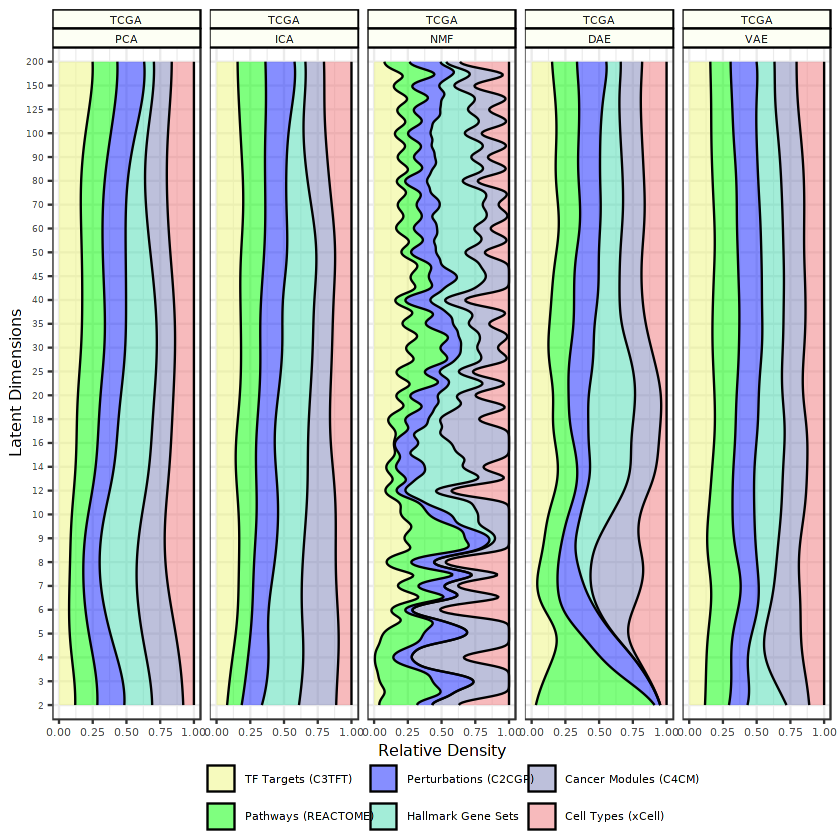

In [13]:
tcga_gg <- plot_top_feature_distribution(tcga_top_df)

tcga_gg

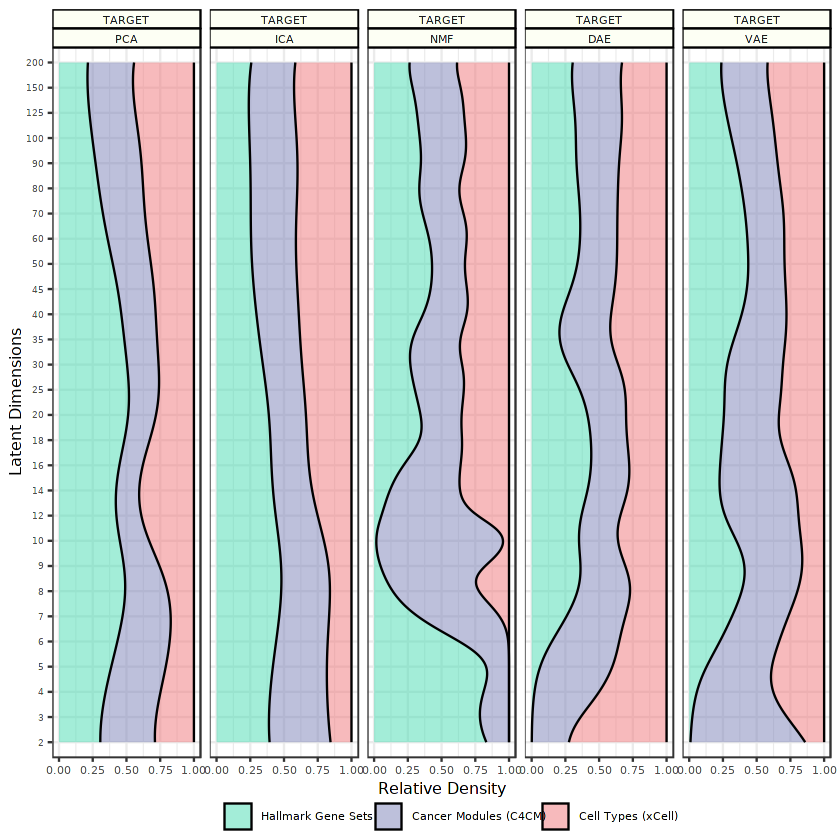

In [14]:
target_gg <- plot_top_feature_distribution(target_top_df, density_how = "fill")

target_gg

In [15]:
theme_gtex <- theme(strip.background = element_rect(colour = "black",
                                                    fill = "#fdfff4"),
                    strip.text.x = element_text(size = 6,
                                                margin = margin(t = 3,
                                                                b = 1.5,
                                                                l = 0,
                                                                r = 0)),
                    axis.title = element_text(size = 9),
                    axis.text.x = element_text(size = 8),
                    axis.text.y = element_text(size = 5),
                    legend.position = 'bottom',
                    legend.title = element_text(size = 8),
                    legend.text = element_text(size = 6),
                    legend.margin = margin(0, 0, 0, 0),
                    legend.box.margin = margin(-8, 0, 0, 0))

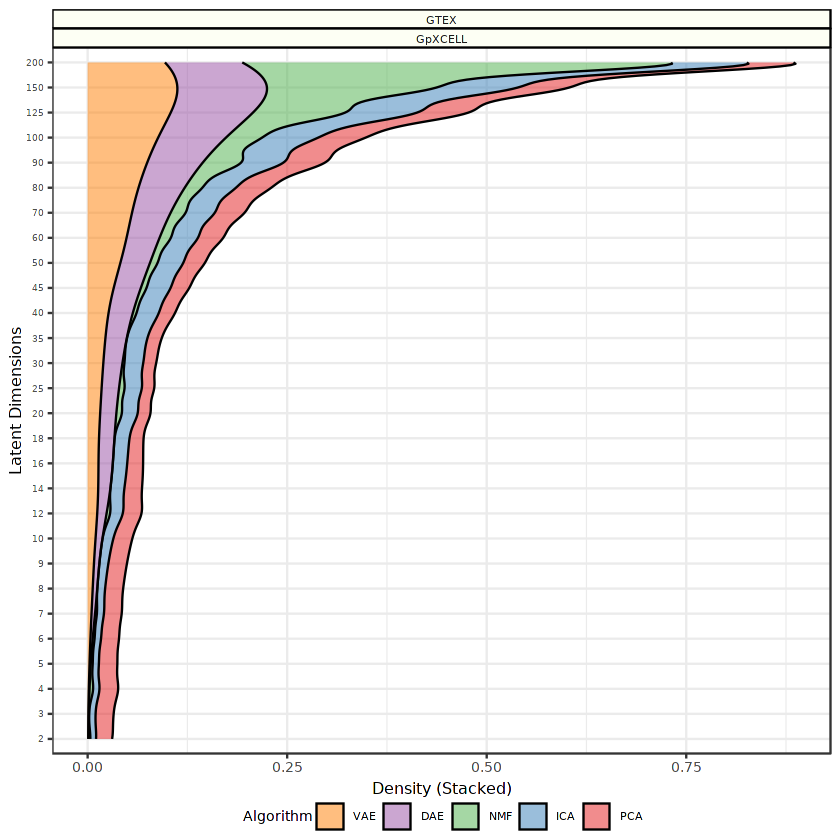

In [16]:
gtex_stack_gg <- ggplot(data = gtex_top_df,
                        aes(x = z, fill = algorithm, group = algorithm)) +
    geom_density(alpha = 0.5, position = "stack") +
    coord_flip() +
    facet_wrap(dataset ~ collection, ncol = 5) +
    xlab("Latent Dimensions") +
    ylab("Density (Stacked)") +
    scale_fill_manual(name = "Algorithm",
                     values = c("#e41a1c",
                                "#377eb8",
                                "#4daf4a",
                                "#984ea3",
                                "#ff7f00")) +
    theme_bw() +
    theme_gtex +
    guides(fill = guide_legend(reverse = T))

gtex_stack_gg

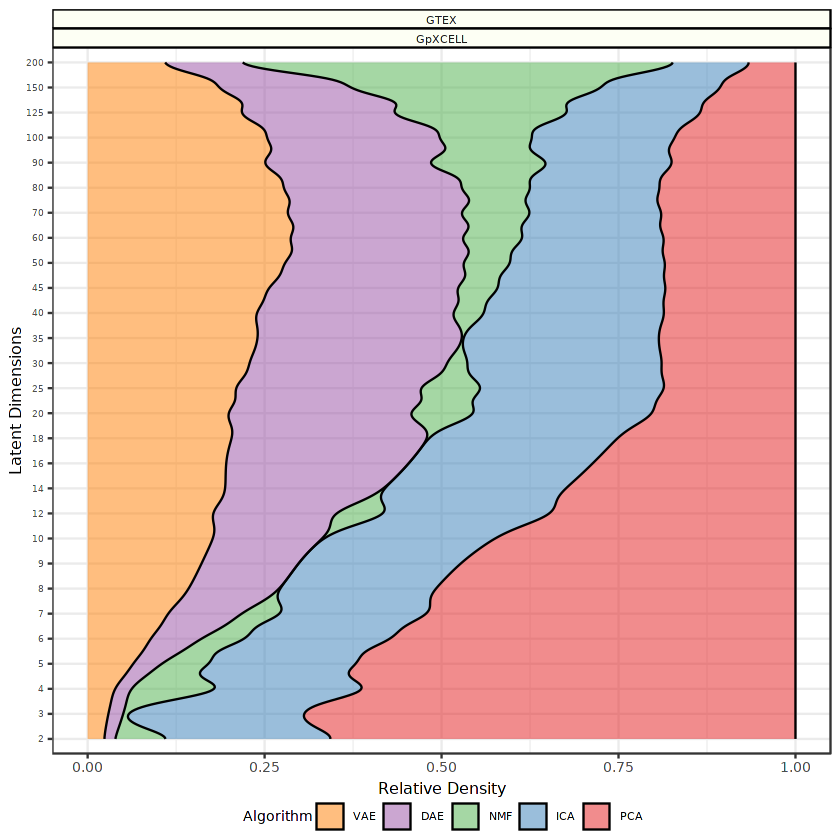

In [17]:
gtex_fill_gg <- ggplot(data = gtex_top_df,
                       aes(x = z, fill = algorithm, group = algorithm)) +
    geom_density(alpha = 0.5, position = "fill") +
    coord_flip() +
    facet_wrap(dataset ~ collection, ncol = 5) +
    xlab("Latent Dimensions") +
    ylab("Relative Density") +
    scale_fill_manual(name = "Algorithm",
                     values = c("#e41a1c",
                                "#377eb8",
                                "#4daf4a",
                                "#984ea3",
                                "#ff7f00")) +
    theme_bw() +
    theme_gtex +
    guides(fill = guide_legend(reverse = T))


gtex_fill_gg

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


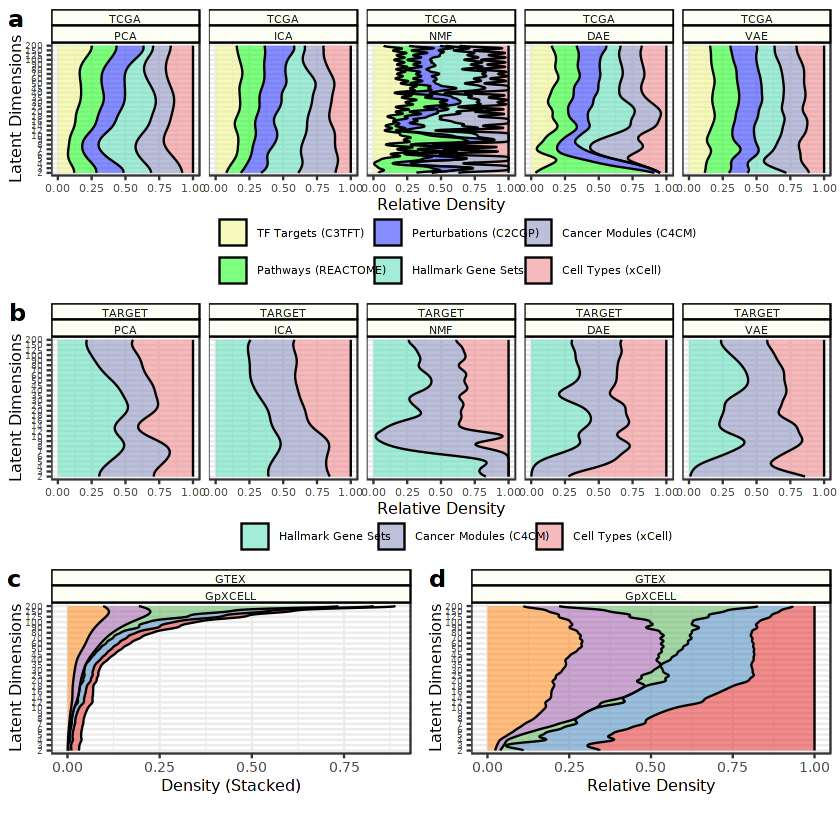

In [18]:
algorithm_legend_gg <- cowplot::get_legend(gtex_fill_gg)

b_and_c_gg <- cowplot::plot_grid(
    gtex_stack_gg + theme(legend.position = "none"),
    gtex_fill_gg + theme(legend.position = "none"),
    ncol = 2,
    labels = c("c", "d")
)

b_and_c_gg <- cowplot::plot_grid(
    b_and_c_gg,
    algorithm_legend_gg,
    rel_heights = c(1, 0.15),
    nrow = 2
)

main_plot <- cowplot::plot_grid(
    tcga_gg,
    target_gg,
    b_and_c_gg,
    nrow = 3,
    rel_heights = c(1.05, 0.95, 1),
    labels = c("a", "b", "")
)

main_plot

In [19]:
for(extension in c('.png', '.pdf')) {
    gg_file <- paste0("top_feature_density", extension)
    gg_file <- file.path("figures", gg_file)
    cowplot::save_plot(filename = gg_file,
                       plot = main_plot,
                       base_height = 210,
                       base_width = 170,
                       units = "mm")
}

# Visualize the Absolute Rank of Gene Set Collections Across Algorithms

In [20]:
all_top_df <- all_top_df %>% dplyr::mutate(feature_num_group = "greater25")
all_top_df$feature_num_group[as.numeric(paste(all_top_df$z)) < 25] <- "less25"

all_top_df$dataset <- factor(all_top_df$dataset, levels = datasets)
all_top_df$feature_num_group <- factor(all_top_df$feature_num_group, levels = c("greater25", "less25"))

In [21]:
# Setup full group parameter
all_top_df$big_group <- paste(all_top_df$feature_num_group, all_top_df$algorithm)

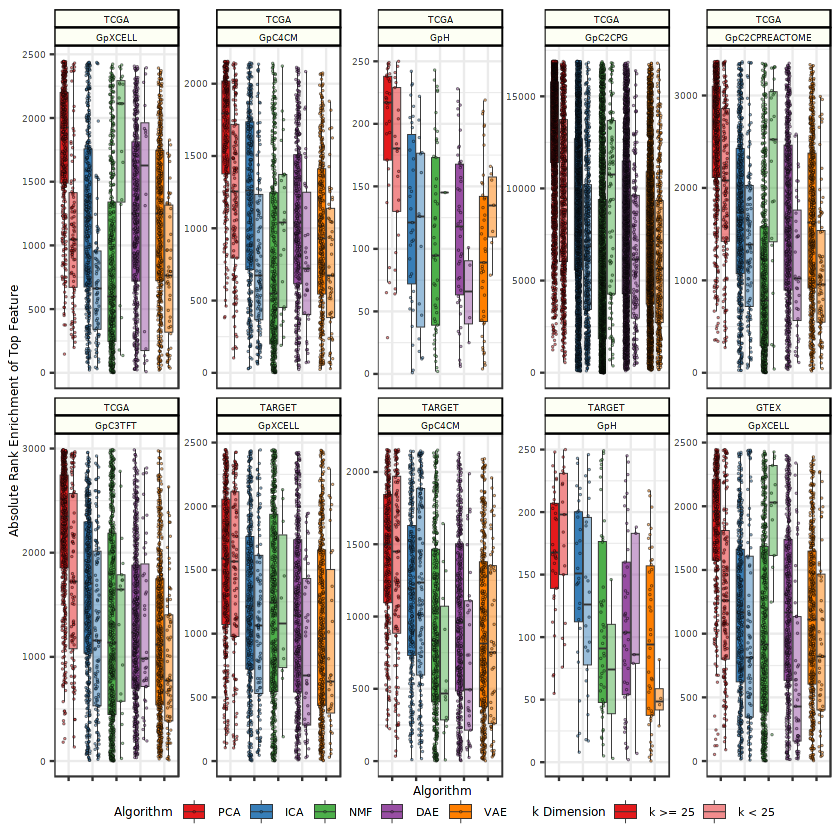

In [22]:
rank_gg <- ggplot(data = all_top_df,
                  aes(x = algorithm,
                      alpha = feature_num_group,
                      y = absolute_rank,
                      fill = algorithm)) +
    geom_boxplot(outlier.alpha = 0,
                 size = 0.2) +
    geom_point(position = position_jitterdodge(dodge.width = 0.75,
                                               jitter.width = 0.6),
               alpha = 0.5,
               size = 0.2,
               pch = 21,
               stroke = 0.3,
               color = '#00000044',
               aes(fill = algorithm,
                   group = big_group)) +
    facet_wrap(dataset ~ collection,
               scales = 'free_y',
               nrow = 2,
               ncol = 5) +
    scale_fill_manual(name = "Algorithm",
                     values = c("#e41a1c",
                                "#377eb8",
                                "#4daf4a",
                                "#984ea3",
                                "#ff7f00"),
                     labels = c("pca" = "PCA",
                                "ica" = "ICA",
                                "nmf" = "NMF",
                                "dae" = "DAE",
                                "vae" = "VAE")) +
    scale_alpha_manual(name = "k Dimension",
                       values = c("less25" = 0.5,
                                  "greater25" = 1),
                       labels = c("less25" = "k < 25",
                                  "greater25" = "k >= 25")) +
    xlab("Algorithm") +
    ylab("Absolute Rank Enrichment of Top Feature") +
    theme_bw() +
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"),
          strip.text.x = element_text(size = 5,
                                      margin = margin(t = 3,
                                                      b = 2,
                                                      l = 0,
                                                      r = 0)),
          legend.position = "bottom",
          legend.text = element_text(size = 6),
          legend.margin = margin(t = -0.4,
                                 b = 0.1,
                                 l = 0.1,
                                 r = 0.1, "cm"),
          legend.title = element_text(size = 7),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 5),
          axis.title.x = element_text(size = 7),
          axis.title.y = element_text(size = 7)) +
    guides(fill = guide_legend(order = 1),
           alpha = guide_legend(override.aes = list(fill = c("less25" = "#e41a1c",
                                                             "greater25" = "#e41a1c")),
                                order = 2))

rank_gg

In [23]:
for(extension in c('.png', '.pdf')) {
    gg_file <- paste0("top_feature_rank", extension)
    gg_file <- file.path("figures", gg_file)
    cowplot::save_plot(filename = gg_file,
                       plot = rank_gg,
                       base_height = 90,
                       base_width = 170,
                       units = "mm")
}